# Анализ поведения пользователей мобильного приложения. Воронки продаж

# Описание проекта

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. 
На основе данных использования мобильного приложения для продажи продуктов питания проанализировать воронку продаж, а также оценить результаты A/A/B-тестирования

# Описание данных 

Каждая запись в логе — это действие пользователя, или событие.

* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Импортирование библиотек

In [ ]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import math as mth
import plotly.express as px
from plotly import graph_objects as go
import plotly.express as px
# импортируем нужные библиотеки для работы

In [ ]:
pd.set_option('display.max_colwidth', 1000) # для выводов всех символов в записях
sns.set(rc={'figure.figsize':(14,10)}) # размеры всех графиков в библиотеке sns
sns.set_style('dark') # стиль графиков
sns.set_palette('pastel') # цветовая палитра

## Изучение общей информации

In [ ]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
# чтение файла

In [ ]:
def first_look(logs):
    display(logs.head(10))
    print('')
    display(logs.info())
    print('')
    display(logs.describe())

first_look(logs)  
# функция для первичного просмотра данных 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


### Вывод:

В предоставленном датафрейме представленна информация из 4 столбцов и 244126 строк. Пропусков в данных нет. Столбец `EventTimestamp` представлен в формате int и имеет 10-ти значное значение, что явно не подходит для информации о времени события. Названия столбцов не имеют "хорошего" стиля. 

## Предобработка данных

### Преобразование столбцов

In [ ]:
logs.columns
# выведем название столбцов

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [ ]:
logs = logs.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp'\
                             , 'ExpId': 'exp_id'})
# переименум столбцы для удобства использования и понимания

In [ ]:
logs.sample(5)
# проверим

,event_name,user_id,event_timestamp,exp_id
10947,PaymentScreenSuccessful,3629479115578224564,1564649357,248
142058,MainScreenAppear,2458857792132229602,1564976295,248
86293,PaymentScreenSuccessful,6276181155690809828,1564828848,246
65266,MainScreenAppear,1321126011609488133,1564762762,247
43237,PaymentScreenSuccessful,6152151620831104215,1564723321,247


### Информация о столбцах

In [ ]:
logs['event_name'].value_counts()
# посмотрим на уникальны значения

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

In [ ]:
logs['event_name'] = logs['event_name'].str.lower()
# преобразование в нижний регистр 

In [ ]:
logs['event_name'].unique()
# проверим

array(['mainscreenappear', 'paymentscreensuccessful', 'cartscreenappear',
       'offersscreenappear', 'tutorial'], dtype=object)

Нам предоставлены 5 событий: 
   * mainscreenappear - переход на главный экран, этого события больше всего в датафрейме (119101)
   * offersscreenappear - переход на экран с предложением (46808)
   * cartscreenappear - переход в корзину (42668)
   * paymentscreensuccessful - переход на страницу оплаты (34118)
   * tutorial - страница с руководстом/обучением (1018)

In [ ]:
logs['user_id'].value_counts()
# уникальные id

6304868067479728361    2308
197027893265565660     2003
4623191541214045580    1771
6932517045703054087    1448
1754140665440434215    1222
                       ... 
8188293597840107588       1
1616856457908967248       1
732356052255400077        1
6671109879025379318       1
2275878174127603404       1
Name: user_id, Length: 7551, dtype: int64

Уникальных пользователей в выгрузке 7551

In [ ]:
logs['exp_id'].value_counts()
# количетсво пользоватлей в группах теста

248    85747
246    80304
247    78075
Name: exp_id, dtype: int64

246 и 247 — контрольные группы, а 248 — экспериментальная. В экспериментальной группе больше всего пользователей

### Пропуски и дубликаты

In [ ]:
logs.isna().sum()
# посмотрим на пропуски методом isna

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Еще раз убедились, что пропусков в данном датафрейме нет.

In [ ]:
print('Количество дубликатов в таблице logs =', logs.duplicated().sum())
# проверим на дубликаты

Количество дубликатов в таблице logs = 413


В таблице присутствует 413 дубликатов. Возможно это связано с ошибкой ввода данных или загрузкой данных. Удалим дубликаты.

In [ ]:
logs = logs.drop_duplicates()
# удалим дубликаты из таблицы

In [ ]:
print('Количество дубликатов в таблице logs =', logs.duplicated().sum())
# проверим результат

Количество дубликатов в таблице logs = 0


### Дата и время

В датафрейме есть столбец `event_timestamp`. В нем дата записана в формате unix timestamp. Преобразуем ее в понятную для нас дату.

In [ ]:
logs['event_date'] = pd.to_datetime(logs['event_timestamp'], unit="s")
# преобразование даты

In [ ]:
logs.sample(5)
# проверим

,event_name,user_id,event_timestamp,exp_id,event_date
208737,mainscreenappear,8712466683546436835,1565116695,247,2019-08-06 18:38:15
225790,offersscreenappear,7586870289028771156,1565177757,247,2019-08-07 11:35:57
43536,mainscreenappear,2207152908861767465,1564724513,248,2019-08-02 05:41:53
239387,mainscreenappear,7215209731030216349,1565199702,248,2019-08-07 17:41:42
160436,mainscreenappear,3848045991888147406,1565013479,248,2019-08-05 13:57:59


Добавим в отдельный столбец только дату

In [ ]:
logs['date'] = logs['event_date'].astype('datetime64[D]')
# выделим дату

In [ ]:
logs.sample(5)
# проверим

,event_name,user_id,event_timestamp,exp_id,event_date,date
2227,mainscreenappear,4612453265087815110,1564608619,247,2019-07-31 21:30:19,2019-07-31
165398,paymentscreensuccessful,3286987355161301427,1565019556,248,2019-08-05 15:39:16,2019-08-05
36115,offersscreenappear,3521696259961091617,1564687965,248,2019-08-01 19:32:45,2019-08-01
90541,mainscreenappear,4070777414461719660,1564834769,247,2019-08-03 12:19:29,2019-08-03
4430,cartscreenappear,8652597388469225782,1564633227,247,2019-08-01 04:20:27,2019-08-01


In [ ]:
first_look(logs)
# датафйрем после предобработки

,event_name,user_id,event_timestamp,exp_id,event_date,date
0,mainscreenappear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,mainscreenappear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,paymentscreensuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cartscreenappear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,paymentscreensuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,cartscreenappear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,offersscreenappear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,mainscreenappear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,mainscreenappear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,mainscreenappear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26



<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


None

,user_id,event_timestamp,exp_id
count,2.437130e+05,2.437130e+05,243713.000000
mean,4.627963e+18,1.564914e+09,247.022161
std,2.642723e+18,1.771388e+05,0.824420
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


### Вывод:

Провели предобработку датафрейма:

   * Преобразовали столбцы к "хорошему" стилю
   * Посмотрели на информацию в каждом столбце 
   * Проверили на пропуски и удалили дубликаты
   * Привели дату и время к подходящему виду и типу для дальнейшего использования.

## Анализ данных

### Сколько всего событий в логе?

In [ ]:
print('Событий в логе:', logs['event_name'].count())

Событий в логе: 243713


### Сколько всего пользователей в логе?

In [ ]:
print('Пользователей в логе:', logs['user_id'].nunique())

Пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [ ]:
print('В среднем событий на пользователя:', (logs['event_name'].count() / logs['user_id'].nunique()).round(0))

В среднем событий на пользователя: 32.0


In [ ]:
logs['user_id'].value_counts().describe()
# метод describe для информации о статистике

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: user_id, dtype: float64

### Период данных

Посмотрим на минимальную и максимальную даты

In [ ]:
print('Минимальная дата -', logs['event_date'].min())

Минимальная дата - 2019-07-25 04:43:36


In [ ]:
print('Максимальная дата -', logs['event_date'].max())

Максимальная дата - 2019-08-07 21:15:17


In [ ]:
logs['event_date'].max() - logs['event_date'].min()
# посчитаем разницу

Timedelta('13 days 16:31:41')

Данные предоставлены с 25 июля 2019 по 07 августа 2019 (2 недели)

Построим гистограмму по дате и времени

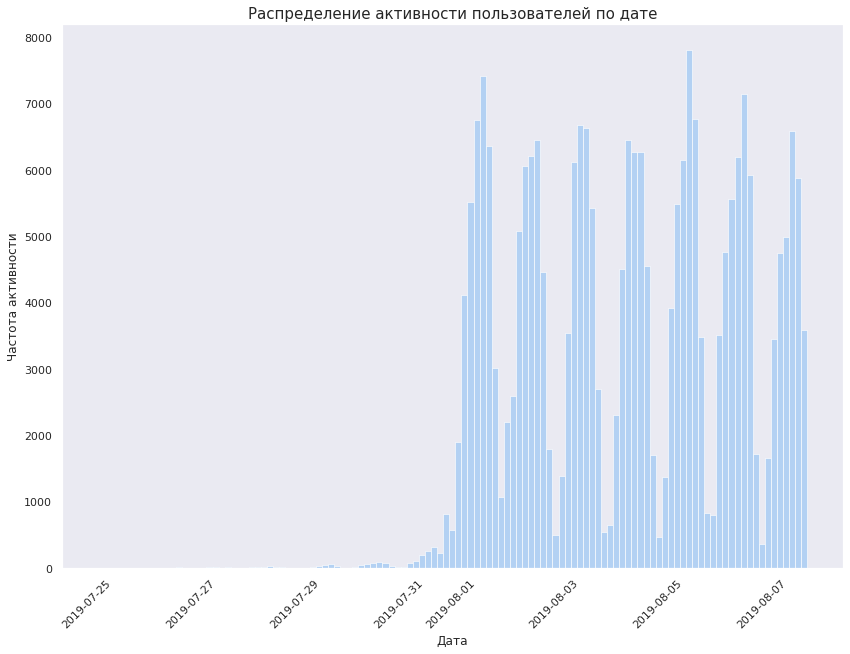

In [ ]:
ax = sns.histplot(data=logs, x='event_date')

ax.set_title('Распределение активности пользователей по дате', size=15)
ax.set_xlabel('Дата', size=12)
ax.set_ylabel('Частота активности', size=12)
plt.xticks(rotation=45)
plt.show()
# гистограмма активности

Из графика видно, что на первой неделе активности пользователей не было. Поэтому данные за первую неделю можно отбросить и считать, что тест начался с 1 августа 2019.

In [ ]:
logs_new = logs.query('date >= "2019-08-01"')
# срез с нужной даты

In [ ]:
logs_new

,event_name,user_id,event_timestamp,exp_id,event_date,date
2828,tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,mainscreenappear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,mainscreenappear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,offersscreenappear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,mainscreenappear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,mainscreenappear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,mainscreenappear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,mainscreenappear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,mainscreenappear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Снова построим график уже с новыми датами

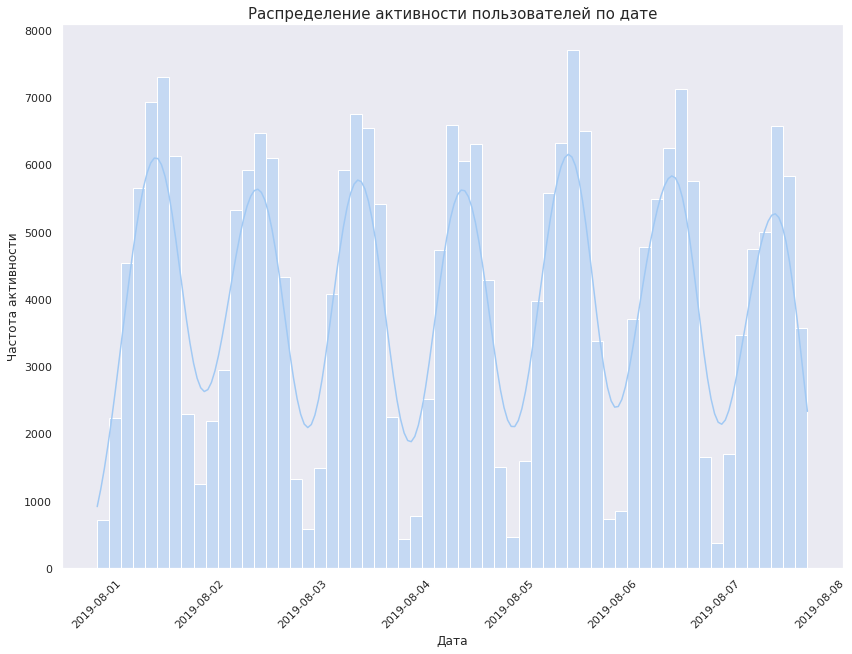

In [ ]:
ax = sns.histplot(data=logs_new, x='event_date', kde=True)

ax.set_title('Распределение активности пользователей по дате', size=15)
ax.set_xlabel('Дата', size=12)
ax.set_ylabel('Частота активности', size=12)
plt.xticks(rotation=45)
plt.show()
# гистограмма активности после среза

Из графика делаем вывод, что мы располагаем полными данными с 1 августа 2019 по 7 августа 2019. Имеем нормальное распределение. Пик активности пользователей приходит на середину дня. Так продолжается на протяжении недели.

### Количество потерянных данных после среза по времени

In [ ]:
print('Событий в логе до среза:', logs['event_name'].count())
print('Событий в логе после среза:', logs_new['event_name'].count())
print('Количество потерянных событий:', logs['event_name'].count() - logs_new['event_name'].count())
# количестов потерянных событий

Событий в логе до среза: 243713
Событий в логе после среза: 240887
Количество потерянных событий: 2826


In [ ]:
print('Пользователей в логе до среза:', logs['user_id'].nunique())
print('Пользователей в логе после среза:', logs_new['user_id'].nunique())
print('Количесвто потерянных пользователей:', logs['user_id'].nunique() - logs_new['user_id'].nunique())
# количестов потерянных пользователей

Пользователей в логе до среза: 7551
Пользователей в логе после среза: 7534
Количесвто потерянных пользователей: 17


После среза по времени мы потеряли 2826 событий и 17 пользователей. Это не существенно для дальнейшего анализа.

### Экспериментальные группы

Проверим, что у нас есть пользователи из трех экспериментальных групп

In [ ]:
logs_new.groupby('exp_id').agg({'user_id':'nunique'})
# группировка по уникальным пользователям

,user_id
exp_id,
246,2484
247,2513
248,2537


Проверим наличие пользователей в двух тестах одновременно

In [ ]:
repeat_users = logs_new.groupby('user_id').agg({'exp_id': 'nunique'})
repeat_users = repeat_users.query('exp_id > 1')
repeat_users.count()
# группировка и подсчет пользователей в двух группах и более

exp_id    0
dtype: int64

В предоставленных данных нет пользователей, которые находятся в двух или трех группах теста одновременно.

### Вывод:

Проанализировав данные выяснили:
  * Изначальное количество событий в логе : 243713
  * Изначальное количество пользователей в логе: 7551
  * В среднем на пользователя приходится 32 события
  * Период изначально предоставленных данных составляет 2 недели (с 25 июля 2019 по 08 августа 2019)
  * Для дальнейшего анализа взяли полные данные с 01 августа по 08 августа (1 неделя)
  * Потери в данных после среза составили 2826 событий и 17 пользователей
  * В каждой из трех экспериментальных групп есть пользователи

## Воронка событий

### Какие события есть в логах

In [ ]:
events = logs_new.groupby('event_name')['user_id'].count().reset_index()\
         .rename(columns={'user_id':'count'}).sort_values(by='count',ascending=False)
events
# сгруппируем данные

,event_name,count
1,mainscreenappear,117328
2,offersscreenappear,46333
0,cartscreenappear,42303
3,paymentscreensuccessful,33918
4,tutorial,1005


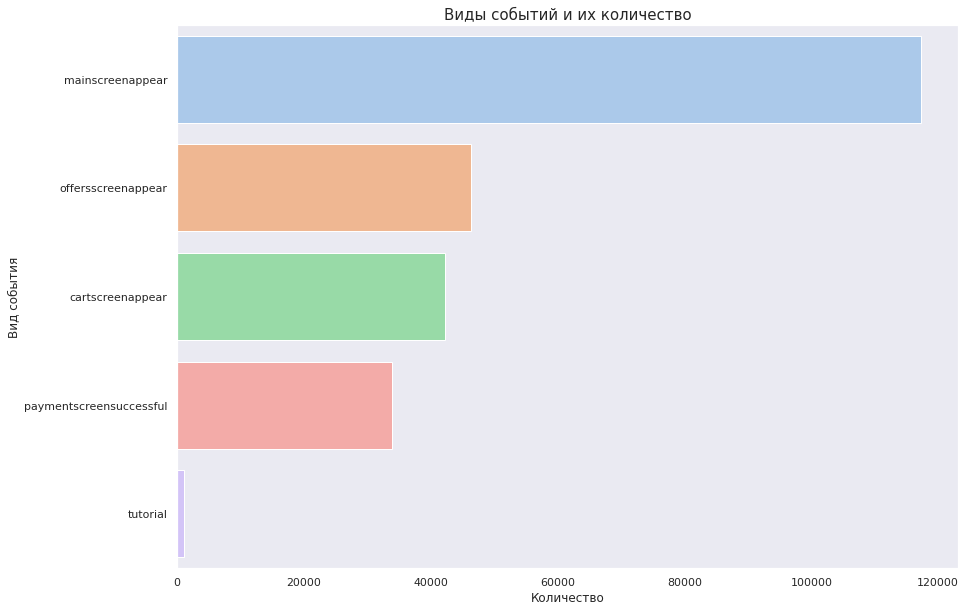

In [ ]:
ax = sns.barplot(data=events, x='count', y='event_name')

plt.title('Виды событий и их количество', fontsize=15)
plt.ylabel('Вид события',fontsize=12)
plt.xlabel('Количество',fontsize=12)
plt.show()
# посмотрим на графике

Работаем со следующими событиями:

   * `mainscreenappear`(переход на главный экран) 
   * `offersscreenappear`(переход на экран с предложением) 
   * `cartscreenappear`(переход в корзину) 
   * `paymentscreensuccessful`(переход на страницу оплаты) 
   * `tutorial`(страница с руководстом/обучением) 

### Сколько пользователей совершали каждое из этих событий. Доля пользователей, которые хоть раз совершали событие.

In [ ]:
users = logs_new.groupby('event_name').agg({'user_id':'nunique'}).reset_index()\
        .rename(columns={'user_id':'unique_count'}).sort_values(by='unique_count', ascending=False)    
users['ratio'] = (users['unique_count'] / logs_new['user_id'].nunique() * 100).round(2)

users
# количество и доля уникальных пользователей, совершающих события

,event_name,unique_count,ratio
1,mainscreenappear,7419,98.47
2,offersscreenappear,4593,60.96
0,cartscreenappear,3734,49.56
3,paymentscreensuccessful,3539,46.97
4,tutorial,840,11.15


Больше всего пользователей заходят на главный экран приложения, их 7419. Что касается обучения, их всего 840, что состовлеят 4% от общего числа уникальных пользователей.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

Порядок событий для  нашей воронки:
 
 * `Главный экран` (mainscreenappear)
 * `Экран с предложением` (offersscreenappear)
 * `Корзина` (cartscreenappear)
 * `Оплата` (paymentscreensuccessfu)
 
Обучение(tutorial) исключаем из анализа. Его слишком мало и не понятно, в каком из экранов события он будет. Его можно проходить как перед переходом на жкран с предложением, так и например перед оплатой. 

### Доля пользователей, прошедшая на следующий шаг воронки

Для того, чтобы посмотреть на долю прошедших пользователей, будем использовать библиотеку plotly и модель funnel(воронка). Там можно посмотреть все в интрекативном варианте.

In [ ]:
users = users.query('event_name != "tutorial"')
users
# уберем из анализа tutorial

,event_name,unique_count,ratio
1,mainscreenappear,7419,98.47
2,offersscreenappear,4593,60.96
0,cartscreenappear,3734,49.56
3,paymentscreensuccessful,3539,46.97


In [ ]:
fig = go.Figure(go.Funnel(
    y=users['event_name'],
    x=users['unique_count'],
    textinfo = 'value+percent initial'))

fig.update_layout(title_text='Количество уникальных пользователей на каждом событии', title_x = 0.5)
fig.show()
# воронка событий

* 62% пользователей, открывших главный экран, переходит на экран с предложением
* 81% пользователей, находящихся на экране с предложением, добавляет товар в корзину
* 95% пользователей, добавивших товар в корзину, оплачивают товар

### На каком шаге теряете больше всего пользователей?

Больше всего пользователей приложение теряет на главном экране. То есть между первым и вторым шагом. Около 40% пользователей не попадают на экран с предложениями. Об этом стоит сообщить руководству. Может быть как раз пользователей не устаивают шрифты в приложении или кнопки для перехода на другие экраны.

### Какая доля пользователей доходит от первого события до оплаты?

Исходя из построенной ранее воронки событий, **48%** доходят с главного экрана до оплаты покупки.

### Вывод:

На данном этапе выяснили:

* В анализе представлены 5 событий : Главный экран, Экран с предложениями, Корзина, Оплата, Обучение
* Построена воронка для видов событий и их количества
* Количество пользователей, посетивших каждую страницу:  
      - Главный экран 7419
      - Экран с предложениями 4593 
      - Корзина 3734 
      - Оплата 3539
      - Обучение 840	
* Больше всего пользователей (2826, примерно 40% от общего числа) теряется между первым и вторым шагом.
* 48% пользователей доходят от первого события до оплаты покупки.     

## Изучение результатов эксперимента

### Количество пользователей в каждой экспериментальной группе

In [ ]:
group = logs_new.groupby('exp_id').agg({'user_id':'nunique'})
group
# пользователи по группам теста

,user_id
exp_id,
246,2484
247,2513
248,2537


В трех группах примерно одинаковое количество пользователей - примерно 2500.

### Находят ли статистические критерии разницу между выборками 246 и 247 (A/A тест)

**Критерии успешного A/A-теста:**
- Количество пользователей в различных группах различается не более, чем на 1%
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно

Из анализа данных знаем, что в предоставленных данных нет пользователей, которые находятся в двух или трех группах теста одновременно. Выделим каждую группу отдельно

In [ ]:
gr_246 = logs_new.query('exp_id == 246 & event_name != "tutorial"')
# срез для группы 246

In [ ]:
gr_247 = logs_new.query('exp_id == 247 & event_name != "tutorial"')
# срез для группы 247

Посчитаем разницу в количестве пользователей групп 247 и 246 в процентах

In [ ]:
group_246 = gr_246.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()\
        .rename(columns={'user_id':'unique_count'}).sort_values(by='unique_count', ascending=False)
group_246
# пользователи из 246 группы

,exp_id,unique_count
0,246,2483


In [ ]:
group_247 = gr_247.groupby('exp_id').agg({'user_id':'nunique'}).reset_index()\
        .rename(columns={'user_id':'unique_count'}).sort_values(by='unique_count', ascending=False)
group_247
# пользователи из 247 группы

,exp_id,unique_count
0,247,2512


In [ ]:
diff = ((group_247.loc[0]['unique_count'] - group_246.loc[0]['unique_count']) / group_246.loc[0]['unique_count'] * 100).round(2)
print('Разница между количеством пользователей групп 246 и 247 -', diff, '%')

Разница между количеством пользователей групп 246 и 247 - 1.17 %


Разницу между группами A/A теста можно округлить до 1% и считать, что это приемлимо для контрольных групп

Посмотрим на воронки событий для групп 246 и 247

In [ ]:
event_246 = gr_246.groupby('event_name').agg({'user_id':'nunique'}).reset_index()\
        .rename(columns={'user_id':'unique_count'}).sort_values(by='unique_count', ascending=False)
event_246
# 246 группа

,event_name,unique_count
1,mainscreenappear,2450
2,offersscreenappear,1542
0,cartscreenappear,1266
3,paymentscreensuccessful,1200


In [ ]:
event_247 = gr_247.groupby('event_name').agg({'user_id':'nunique'}).reset_index()\
        .rename(columns={'user_id':'unique_count'}).sort_values(by='unique_count', ascending=False)
event_247
# 247 группа

,event_name,unique_count
1,mainscreenappear,2476
2,offersscreenappear,1520
0,cartscreenappear,1238
3,paymentscreensuccessful,1158


In [ ]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group 246',
    y = event_246['event_name'],
    x = event_246['unique_count'],
    ))

fig.add_trace(go.Funnel(
    name = 'group 247',
    y = event_247['event_name'],
    x = event_247['unique_count'],
    ))

fig.show()
# воронка событий для групп 246 и 247

По воронке можно сказать, что для обеих групп фиксируют и отправляют в системы аналитики данные об одном и том же, то есть о количестве пользователей на каждом событии. Различия не велики. Поэтому будем считать, что А/А тест успешен.

### Cамое популярное событие. Число пользователей, совершивших это событие в каждой из контрольных групп. Доля пользователей, совершивших это событие. Проверка на статистическую значимость

In [ ]:
event_pivot = logs_new.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')\
              .sort_values(by=246, ascending=False)

event_pivot['246+247'] = event_pivot[246] + event_pivot[247]
event_pivot.drop(['tutorial'], inplace=True)
event_pivot
# количество пользователей разных групп для каждого события

exp_id,246,247,248,246+247
event_name,,,,
mainscreenappear,2450,2476,2493,4926
offersscreenappear,1542,1520,1531,3062
cartscreenappear,1266,1238,1230,2504
paymentscreensuccessful,1200,1158,1181,2358


Самое популярное событие : mainscreenappear(Главный экран) для всех групп. До страницы оплаты больше всего пользователей дошли из 246 группы

In [ ]:
group
# таблица общего числа пользователей для групп

,user_id
exp_id,
246,2484
247,2513
248,2537


Для анализа нужно добавить общее число пользоватлей для групп 246 и 247

In [ ]:
group = group.reset_index()
group.loc[3] = ['246+247', 4997]
group = group.set_index(group.columns[0])
group
# результат

,user_id
exp_id,
246,2484
247,2513
248,2537
246+247,4997


Далее напишем функцию для проверки гипотез для доли/пропорции. Внутри функции будем считать эти доли и проводить проверку на стат значимость с помощью z-теста

**Сформулируем гипотезы:**

* Н0 - Статистическая значимость долей(пропорций) каждого события между выборками 246 и 247, равна (статистически не значимы)

* Н1 - Статистическая значимость долей(пропорций) каждого события между выборками 246 и 247, не равна (статистически значимы)

Критический уровень статистической значимости alpha примем за 5%

In [ ]:
def z_test(group_1, group_2, event_name, alpha): 
    
    p1_event = event_pivot.loc[event_name, group_1]  # кол-во пользователей для события в первой группе
    p2_event = event_pivot.loc[event_name, group_2] # кол-во пользоватлей для события во второй группе
    p1_all = group.loc[group_1, 'user_id'] # общее кол-во пользователей в первой группе
    p2_all = group.loc[group_2, 'user_id'] # общее кол-во пользователей во второй группе группе
   
    p1 = p1_event / p1_all # пропорция успехов в первой группе
    p2 = p2_event / p2_all # пропорция успехов во второй группе
    
    difference = p1 - p2 # разница пропорций в датасетах
    p_combined = (p1_event + p2_event) / (p1_all + p2_all) #пропорция успехов в комбинированном датасете
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_all + 1 / p2_all)) 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    
    distr = stats.norm(0, 1) # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие:' , event_name)
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
# функция z-теста        

In [ ]:
for event_name in event_pivot.index:
    z_test(246, 247, event_name, 0.05)
    print()

Событие: mainscreenappear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: offersscreenappear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: cartscreenappear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: paymentscreensuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**

Между группами A/A теста (246 и 247), совершавшими каждое из представленных событий, нет статистической разницы между долями.

### А/B тест. Сравним результаты с каждой из контрольных групп и с объединенной контрольной группой по каждому из событий

#### 246 и 248 группы

In [ ]:
for event_name in event_pivot.index:
    z_test(246, 248, event_name, 0.05)
    print()

Событие: mainscreenappear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: offersscreenappear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: cartscreenappear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: paymentscreensuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### 247 и 248 группы 

In [ ]:
for event_name in event_pivot.index:
    z_test(247, 248, event_name, 0.05)
    print()

Событие: mainscreenappear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: offersscreenappear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: cartscreenappear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: paymentscreensuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



#### Объединенные группы 246,247 и 248

In [ ]:
for event_name in event_pivot.index:
    z_test('246+247', 248, event_name, 0.05)
    print()

Событие: mainscreenappear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: offersscreenappear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: cartscreenappear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: paymentscreensuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**

В результате проведения экмперимента различия между контрольными группами и экспериментальной статистически не значимы.

### Проверки статистических гипотез

В ходе исследования мы провели:

* 4 А/А теста
* 12 А/Б тестов
* 16 тестов всего

Благодаря данным проверкам, статистические различия между долями оказались не значимыми.

### Вывод

* определили сколько пользоватлей в каждой группе
* проверили A/A тест по критериям успешности
* выяснили самое популярное событие
* благодаря проверкам с помощью z-теста, можно сказать, что изменение шрифта никак не повлияло на метрики нашей воронки.

## Вывод:

В результате нашего исследования было выполнено следующее:

1.  Провели предобработку датафрейма:

    - Преобразовали столбцы к "хорошему" стилю
    - Посмотрели на информацию в каждом столбце
    - Проверили на пропуски и удалили дубликаты
    - Привели дату и время к подходящему виду и типу для дальнейшего использования.
 
 
2. Проанализировали данные

   - Изначальное количество событий в логе : 243713
   - Изначальное количество пользователей в логе: 7551
   - В среднем на пользователя приходится 32 события
   - Период изначально предоставленных данных составляет 2 недели (с 25 июля 2019 по 08 августа 2019)
   - Для дальнейшего анализа взяли полные данные с 01 августа по 08 августа (1 неделя)
   - Потери в данных после среза составили 2826 событий и 17 пользователей


3. Исследовали воронку событий

    - В анализе представлены 5 событий : Главный экран, Экран с предложениями, Корзина, Оплата, Обучение
    - Построена воронка для видов событий и их количества
    - Количество пользователей, посетивших каждую страницу:
        * Главный экран 7419
        * Экран с предложениями 4593 
        * Корзина 3734 
        * Оплата 3539
        * Обучение 840    
    - Больше всего пользователей (2826, примерно 40% от общего числа) теряется между первым и вторым шагом.
    - 48% пользователей доходят от первого события до оплаты покупки.
    
    
4. Провели результаты А/А/B тестирования

     - определили сколько пользоватлей в каждой группе
     - проверили A/A тест по критериям успешности
     - выяснили самое популярное событие
     - благодаря проверкам с помощью z-теста, можно сказать, что изменение шрифта никак не повлияло на метрики нашей воронки.
     

Можно смело передать менеджерам, что никаких изменений в метриках и поведении пользователей не произошло после изменения шрифта во всем приложении. Можно дать добро дизайнерам, либо провести другой тест.
